In [1]:
# import requests
# from datetime import datetime

# ## Get prices from API
# # Hourly data
# days = 80
# r = requests.get(f'https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&interval=5minutes&days={days}')
# prices = [(datetime.fromtimestamp(x[0] / 1000, tz=None), x[1]) for x in r.json()['prices']]

# print(len(prices))


In [2]:
## Requirements:
# mgarch
# numpy
# pandas
# matplotlib
# scipy
# seaborn
# distfit


In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import mgarch
from distfit import distfit
from scipy.stats import multivariate_t, norm, t
import numpy as np
from scipy import special


sns.set_theme(style="whitegrid")

# Monte carlo: https://github.com/GreatSoshiant/Monte-Carlo/blob/master/Code/Monte-Carlo.py


data_folder = Path("./data")


In [4]:
# Mapping symbol to tags
symbol_tags = {}
with data_folder.joinpath("symbolTags.txt").open() as f:
    for line in f:
        symbol, tags = line.strip().split(":")
        symbol_tags[symbol] = tags.split(",")

# print(symbol_tags)

# Mapping tags to symbol
tag_groups = {}
for symbol, tags in symbol_tags.items():
    for tag in tags:
        if tag not in tag_groups:
            tag_groups[tag] = []
        tag_groups[tag].append(symbol)

print(tag_groups["mineable"])


['BTC', 'ETH', 'ADA', 'DOGE', 'ETC', 'LTC', 'XMR', 'BCH', 'FIL', 'BSV', 'HNT', 'ZEC', 'STX', 'ZIL', 'DASH', 'BTG', 'DCR', 'RVN']


### Price Data


In [5]:
dfs = []
for data_file in data_folder.glob("*.csv"):
    dfs.append(pd.read_csv(data_file))
data = pd.concat(dfs)


In [6]:
# Some basic ordering and converting time
data = data.sort_values("time").reset_index(drop=True)
data["time"] = pd.to_datetime(data["time"], unit="ms")
data


,time,symbol,id,fully_diluted_market_cap,percent_change_1h,last_updated,percent_change_24h,market_cap,volume_change_24h,price,volume_24h,market_cap_dominance,percent_change_7d
0,2022-08-26 02:16:50.534,LINK,1975,7.095125e+09,0.406862,2022-08-26T02:10:00.000Z,-2.153093,3.338966e+09,7.2071,7.095125,3.353362e+08,0.3210,-5.173806
1,2022-08-26 02:16:50.534,SAND,6210,3.143179e+09,0.701362,2022-08-26T02:10:00.000Z,-0.664941,1.495651e+09,-5.1957,1.047726,2.237651e+08,0.1437,-5.679735
2,2022-08-26 02:16:50.534,ALGO,4030,3.068100e+09,0.645585,2022-08-26T02:10:00.000Z,0.518193,2.116577e+09,7.2384,0.306810,7.206386e+07,0.2035,-4.458272
3,2022-08-26 02:16:50.534,YFI,5864,3.568622e+08,0.300028,2022-08-26T02:10:00.000Z,2.266948,3.565870e+08,42.1266,9732.783402,7.521861e+07,0.0343,-0.450687
4,2022-08-26 02:16:50.534,XMR,328,2.804769e+09,0.867606,2022-08-26T02:10:00.000Z,1.290014,2.804769e+09,-11.6385,154.398287,8.082145e+07,0.2696,-0.936000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1517395,2069-10-10 13:16:23.343,OKB,3897,4.902748e+09,-0.088834,2022-10-29T16:39:00.000Z,1.347230,9.805495e+08,10.2374,16.342492,2.359049e+07,0.0950,4.614361
1517396,2069-10-10 13:16:23.343,TUSD,2563,8.225137e+08,-0.029758,2022-10-29T16:40:00.000Z,-0.058259,8.225137e+08,15.7312,0.999800,3.867076e+07,0.0797,-0.002963
1517397,2069-10-10 13:16:23.343,DASH,131,8.272718e+08,0.731230,2022-10-29T16:39:00.000Z,3.409161,4.806751e+08,2.8587,43.770993,7.972535e+07,0.0466,7.089465
1517398,2069-10-10 13:16:23.343,EOS,1765,1.219369e+09,0.603293,2022-10-29T16:39:00.000Z,0.344441,1.154409e+09,-36.9817,1.149256,2.007905e+08,0.1118,9.093761


In [7]:
symbol = "ETH"
d = data[data["symbol"] == symbol].sort_values("time")
filter = d["time"].diff() > pd.Timedelta(5, unit="min")
d[filter]


,time,symbol,id,fully_diluted_market_cap,percent_change_1h,last_updated,percent_change_24h,market_cap,volume_change_24h,price,volume_24h,market_cap_dominance,percent_change_7d
113102,2022-09-07 03:15:34.870,ETH,1027,1.837795e+11,-1.423048,2022-09-07T03:09:00.000Z,-8.225033,1.837795e+11,40.3793,1503.065347,2.193732e+10,19.7170,-5.554876
350208,2022-09-30 07:37:48.914,ETH,1027,1.644686e+11,0.704323,2022-09-30T07:31:00.000Z,1.648734,1.644686e+11,-18.1144,1341.640752,1.359222e+10,17.3527,0.138402
405308,2022-10-07 04:31:02.846,ETH,1027,1.665877e+11,0.082215,2022-10-07T04:24:00.000Z,-1.453767,1.665877e+11,-1.7145,1357.831699,1.084019e+10,17.3827,2.205914
606290,2022-10-17 02:51:23.343,ETH,1027,1.591363e+11,-0.245909,2022-10-17T02:45:00.000Z,1.475779,1.591363e+11,13.8600,1300.410962,7.672876e+09,17.3033,-1.950373
968205,2022-11-04 03:50:04.415,ETH,1027,1.890133e+11,0.293386,2022-11-04T03:43:00.000Z,-0.365880,1.890133e+11,-45.4899,1544.555811,1.318157e+10,18.7181,2.444018
1517292,2023-10-15 22:46:02.846,ETH,1027,1.633449e+11,0.039993,2022-10-14T03:50:00.000Z,3.351388,1.633449e+11,125.7609,1330.326132,1.924979e+10,17.3266,-1.954598
1517306,2069-10-10 13:16:23.343,ETH,1027,2.001340e+11,0.087826,2022-10-29T16:39:00.000Z,5.178390,2.001340e+11,-5.5760,1635.430998,2.091086e+10,19.3896,24.519099


In [8]:
# For each symbol create column of prices (index is time)
df = data.set_index(["time", "symbol"])["price"].unstack(level=-1)
df


symbol,1INCH,AAVE,ADA,ALGO,APE,AR,ATOM,AVAX,AXS,BAT,...,WBTC,XEC,XEM,XLM,XMR,XRP,XTZ,YFI,ZEC,ZIL
time,,,,,,,,,,,,,,,,,,,,,
2022-08-26 02:16:50.534,0.743581,92.106255,0.465236,0.306810,5.330483,12.224521,12.712558,22.995289,14.786041,0.374049,...,21543.752080,0.000040,0.048451,0.110031,154.398287,0.347516,1.665226,9732.783402,66.961755,0.039538
2022-08-26 02:21:50.534,0.743650,92.079884,0.465062,0.306487,5.328189,12.215205,12.703237,22.975153,14.782047,0.373989,...,21544.377158,0.000040,0.048404,0.110013,154.262970,0.347483,1.664208,9731.419387,66.962568,0.039519
2022-08-26 02:26:50.534,0.744097,92.080754,0.465427,0.306702,5.338800,12.217961,12.708587,22.991750,14.842915,0.374024,...,21552.183833,0.000040,0.048459,0.110046,154.400551,0.347452,1.664878,9736.025589,66.960216,0.039547
2022-08-26 02:31:50.534,0.745604,92.066538,0.466018,0.306961,5.337663,12.228138,12.716926,23.023857,14.856808,0.374327,...,21569.445802,0.000040,0.048447,0.110146,154.408807,0.347428,1.667689,9742.923950,67.040458,0.039570
2022-08-26 02:36:50.534,0.745369,92.063457,0.466087,0.306935,5.332004,12.218987,12.699933,23.021945,14.835072,0.374278,...,21567.087766,0.000040,0.048435,0.110141,154.278477,0.347333,1.668850,9742.352976,67.120562,0.039550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-23 05:05:04.415,0.537699,57.765571,0.316830,0.243990,3.332316,9.352185,9.868191,12.721469,6.879791,0.228588,...,16450.149882,0.000029,0.032704,0.088279,135.575137,0.377827,0.991723,6317.495663,43.182581,0.022171
2022-11-23 05:10:04.415,0.537489,57.753122,0.317135,0.243973,3.329331,9.345284,9.861506,12.723437,6.880911,0.228487,...,16443.480221,0.000029,0.032698,0.088249,135.521520,0.377742,0.991710,6306.480426,43.149659,0.022175
2022-11-23 05:15:04.415,0.537026,57.678442,0.317545,0.243857,3.330448,9.323874,9.853415,12.705030,6.886673,0.228283,...,16443.530504,0.000029,0.032707,0.088223,135.466890,0.377147,0.991901,6295.208941,43.005981,0.022166


In [9]:
symbol = "ADA"


def log_returns(array):
    """Calculate log returns of given list/ndarray/pd.Series."""
    return np.diff(np.log(array), axis=0)


returns = pd.DataFrame(log_returns(df), columns=df.columns)
print("Original len", len(returns))

# Filter out returns which are for longer time periods than 6 minutes (there are some time jumps in data)
returns = returns[np.diff(df.index) < pd.Timedelta(6, "m")]
returns


# min and max values

df2 = df[:-1]
df3 = df2[np.diff(df.index) < pd.Timedelta(6, "m")]

print(min(df3.index))
print(min(df3.columns))
print(min(df3["DAI"]))
print(max(df3["DAI"]))
print(min(df3["USDT"]))
print(max(df3["USDT"]))
print(min(df3["USDC"]))
print(max(df3["USDC"]))
print(min(df3["BUSD"]))
print(max(df3["BUSD"]))
print(min(df3["TUSD"]))
print(max(df3["TUSD"]))

Original len 15173
2022-08-26 02:16:50.534000
1INCH
0.9920982174516808
1.0061686511990895
0.9833829140106622
1.0004881993548662
0.9991337172192458
1.0073301552810212
0.9988460436925104
1.0126380598696292
0.993716330515332
1.0055883312559109


[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 1.04179e+06] [loc=-0.000 scale=0.002]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 3.12614e+06] [loc=-0.043 scale=0.043]
[distfit] >INFO> [pareto    ] [0.01 sec] [RSS: 3.12614e+06] [loc=-4194304.043 scale=4194304.000]
[distfit] >INFO> [dweibull  ] [0.60 sec] [RSS: 127151] [loc=-0.000 scale=0.001]
[distfit] >INFO> [t         ] [0.61 sec] [RSS: 27972.9] [loc=0.000 scale=0.001]
[distfit] >INFO> [genextreme] [0.88 sec] [RSS: 2.0044e+06] [loc=-0.001 scale=0.004]
[distfit] >INFO> [gamma     ] [0.83 sec] [RSS: 3.34929e+06] [loc=-0.043 scale=1.838]
[distfit] >INFO> [lognorm   ] [0.62 sec] [RSS: 1.04055e+06] [loc=-0.896 scale=0.896]
[distfit] >INFO> [beta      ] [1.93 sec] [RSS: 1.04303e+06] [loc=-0.581 scale=0.966]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 3.05071e+06] [loc=-0.043 scale=0.079]
[distfit] >INFO> [loggamma  ] [0.24 sec] [RSS: 1.04613e+06] [loc=-0.476 scale=0.068]
[distfit] >INFO>

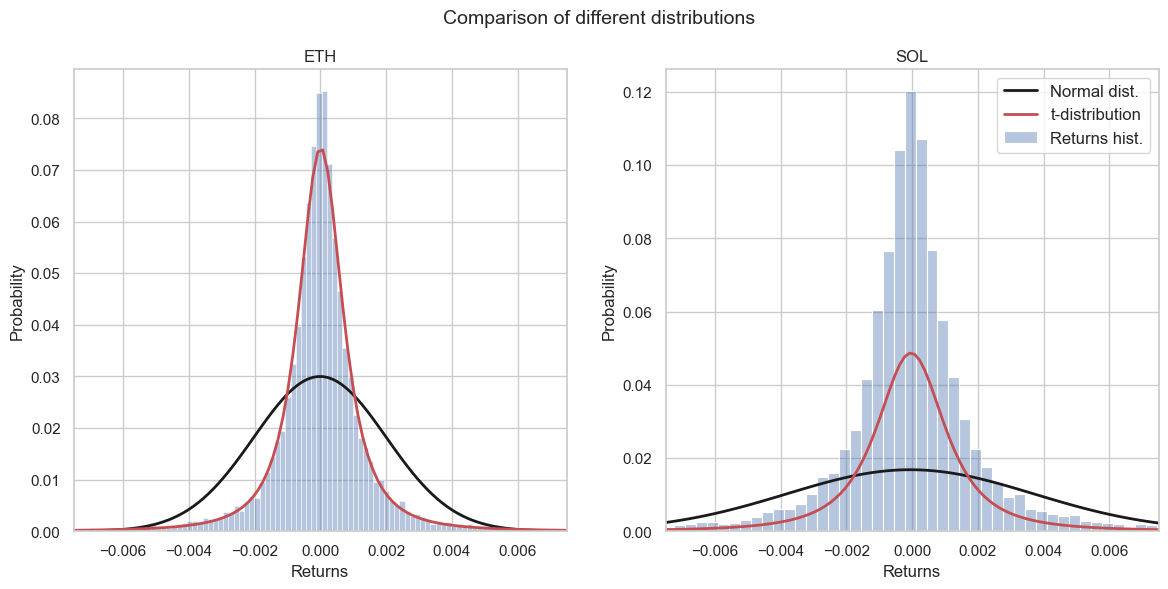

In [10]:
def get_p_values(ax, dist, r):
    """Get p values for plotting distribution."""
    params = dist.fit(r)
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    pdf = dist.pdf(x, *params)
    return x, pdf / np.sum(pdf)


fig, axs = plt.subplots(1, 2, figsize=(14, 6))
plt.suptitle("Comparison of different distributions", fontsize=14)
for symbol, ax in zip(["ETH", "SOL"], axs):
    r = returns[symbol]
    # Determine best-fitting probability distribution for data
    dist = distfit()
    dist.fit_transform(r)

    ax.set_title(symbol)
    ax.set_xlabel(f"Returns", fontsize=12)
    ax.set_ylabel(f"Probability", fontsize=12)
    ax.set_xlim((-0.0075, 0.0075))

    # Plot histogram of returns
    # ax.hist(r, bins=500, alpha=0.4, label="Returns hist.", density=True)
    sns.histplot(
        r, bins=500, alpha=0.4, label="Returns hist.", stat="probability", ax=ax
    )

    # # Plot normal distribution
    x, p = get_p_values(ax, norm, r)
    ax.plot(x, p, "k", linewidth=2, label="Normal dist.")

    # # Plot t-distribution
    x, p = get_p_values(ax, t, r)
    ax.plot(x, p, "r", linewidth=2, label="t-distribution")

# plt.tight_layout()
plt.legend(fontsize=12)
plt.show()


<Axes: xlabel='symbol', ylabel='symbol'>

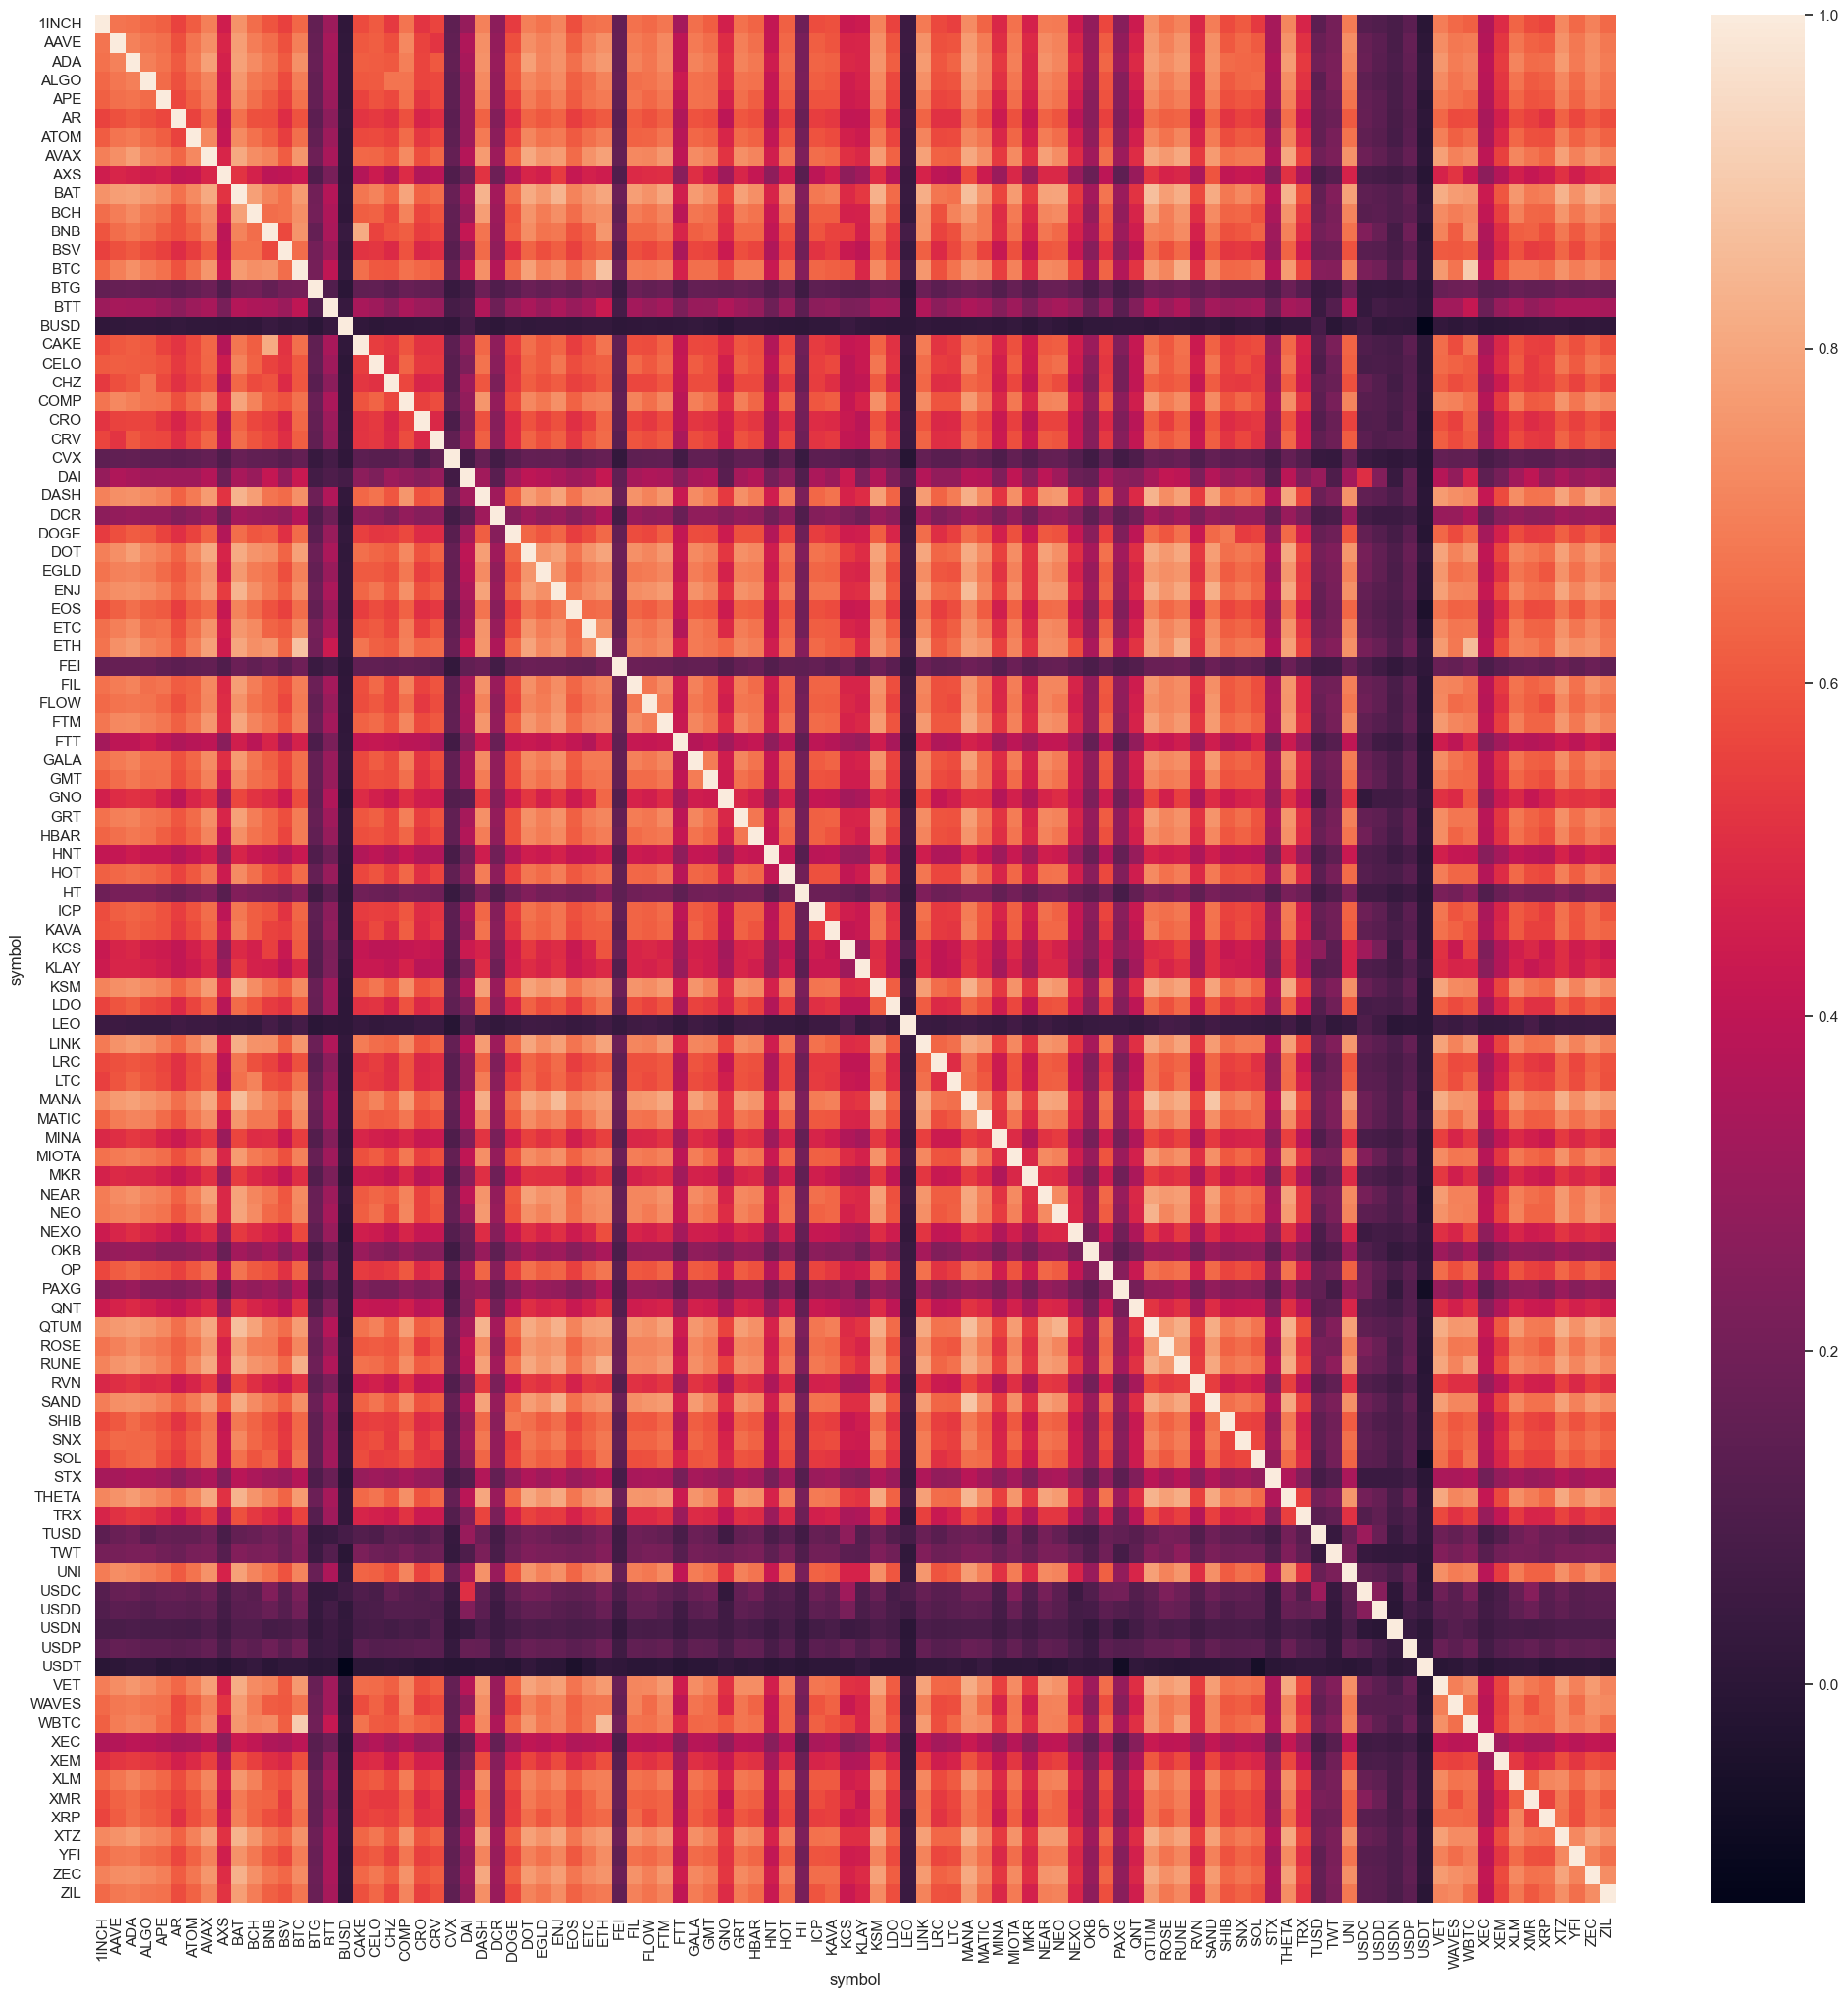

In [11]:
plt.figure(figsize=(25, 25))
sns.heatmap(returns.corr())


# Notes

We can define new variable $\gamma$ representing initial overcollaterization (ratio between collected value and value of issued stable coin). We can write:

$$
\gamma = \frac{\sum_j \alpha_j p_j(0)}{x},
$$

where $x$ is amount of issued stablecoins, $p_j(0)$ and $\alpha_j$ is the initial price and amount of token $j$.
Deriving the formula for $x$ and substituting it into the original condition of expected overcolaterization.
\begin{aligned}
x &= \frac{\sum_j \alpha_j p_j(0)}{\gamma} \\
\sum_j \alpha_j p_j(t) &\leq \frac{\sum_j \alpha_j p_j(0)}{\gamma} \theta \\
\left(\frac{\text{Current value}}{\text{Initial value}}=\right) \frac{\sum_j \alpha_j p_j(t)}{\sum_j \alpha_j p_j(0)}&\leq \frac{\theta}{\gamma}
\end{aligned}
Therefore the condition doesn't depend on absolute value of portfolio. We can scale all $\alpha_j$ by any constant other than 0 without affecting the condition.

<span style="color: red;">Consider minimum variance portfolio - trading for minimum variance</span>


### Assuming that we have fixed proportion of asset in portfolio


In [12]:
def sem(values):
    """Calculate standard error of mean."""
    return np.std(values, ddof=1) / np.sqrt(np.size(values))


class Simulation:
    def __init__(
        self, returns, portfolio, initial_overcol, expected_overcol, time_block
    ):
        """Initialize simulation object with given portfolio defined by values.

        Args:
            returns: dataframe with log returns for different tokens
            portfolio: portfolio defined as mapping of token to percentage in portfolio
            initial_overcol: value of initial overcollaterization
            expected_overcol: value of expected overcollaterization
            time_block: size of historical time block to use for the simulation
        """
        self.returns = returns
        self.portfolio = portfolio
        self.initial_value = sum(portfolio.values())
        self.expected_overcol = expected_overcol

        self.update_initial_overcol(initial_overcol)

        self._symbols = list(portfolio.keys())
        self._v = np.array(list(portfolio.values()))

        self.time_block = time_block
        self.volatility = self._get_volatility()
        self.means = self._get_mean()

        self.periods = len(self.means)

        print(f"Periods: {self.periods}")
        print(f"Mean: {self.means}")
        print(f"Vol: {self.volatility}")

    def update_initial_overcol(self, initial_overcol):
        """Update value of initial over-collaterization."""
        self.initial_overcol = initial_overcol
        self.critical_value = self.initial_value * self.expected_overcol / self.initial_overcol

    def _get_volatility(self):
        """Calculate volatility of portfolio given by values."""
        vols = []
        for i in range(0, len(self.returns), self.time_block):
            cov = self.returns.loc[i : i + self.time_block, self._symbols].cov()
            vols.append(((self._v @ cov @ self._v.T) ** 0.5) / self._v.sum())
        return vols

    def _get_mean(self):
        """Calculate mean of portfolio given by values."""
        means = []
        for i in range(0, len(self.returns), self.time_block):
            mean = self.returns[self._symbols].values[i : i + self.time_block].mean(axis=0)
            means.append(self._v @ mean)
        return means

    def _check_condition(self, values):
        """Check if the condtion for expected overcolaterization was broken at some point."""
        return any(values <= self.critical_value)

    def value_simulation(self, steps, period=0):
        """Simulate one value (price) path using GBM based on mu and sigma."""
        dt = 1
        mean = self.means[period]
        volatility = self.volatility[period]

        returns = np.exp(
            (mean - volatility**2 / 2) * dt
            + volatility * np.random.normal(0, np.sqrt(dt), size=(steps, 1))
        )
        returns = np.vstack([[1], returns])
        values = self.initial_value * returns.cumprod(axis=0)
        return values

    def simulate(self, sim_days, runs, log=True):
        """Run the simulation and calculate the percentage of failures.

        Args:
            sim_days: number of days to simulate
            runs: number of runs of the simulation
            log: print final results if true
        """
        n_steps = int(sim_days * 24 * 60 / 5)

        stats = []
        for i in range(runs):
            period = i % self.periods
            values = self.value_simulation(n_steps, period)
            failed = self._check_condition(values)
            stats.append(failed)

        stats = np.array(stats)
        if log:
            print(f"{stats.mean()} +- {sem(stats)}")
        return stats, stats.mean()


In [13]:
# Parameters:
portfolio = {"BTC": 0.5, "ETH": 0.5}
sim_days = 1
initial_overcol = 1.2
expected_overcol = 1.1
# How many days of historical data to use for simulation
time_block = int(7 * (24 * 60 / 5))

sim = Simulation(returns, portfolio, initial_overcol, expected_overcol, time_block)

# Simulation (for T=1 day, 100000 runs)
_ = sim.simulate(sim_days, 100000)


Periods: 8
Mean: [3.1190684668011384e-05, -4.280897891651729e-05, -6.384906458619516e-06, 1.3207221769977911e-05, 9.268670984672163e-05, -0.00012423214011432284, -1.3082963671177486e-05, -2.23779724808271e-05]
Vol: [0.0014903285561325271, 0.0016782579143553747, 0.0010037935147006515, 0.00074552446677176, 0.0013713341324605639, 0.003169883373728718, 0.0013888896349384602, 0.0013232624173180392]
0.03401 +- 0.0005731810223348672


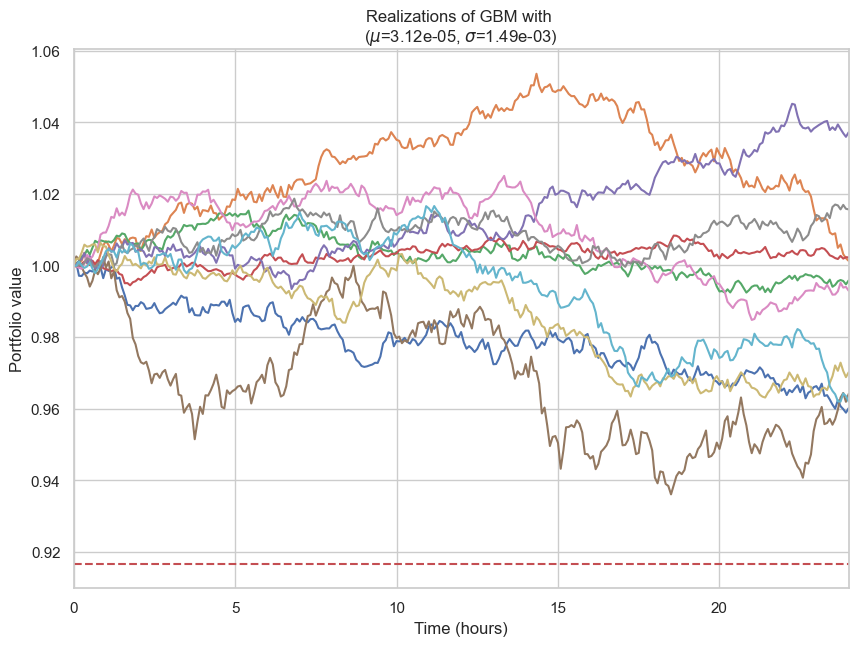

In [14]:
plt.figure(figsize=(10, 7))
n_steps = int(sim_days * 24 * 60 / 5)
x_values = [(i * 5) / 60 for i in range(n_steps + 1)]
# Visualisation
for x in range(10):
    values = sim.value_simulation(n_steps, x % sim.periods)
    plt.plot(x_values, values)

plt.axhline(y=sim.critical_value, color="r", linestyle="--")
plt.xlabel("Time (hours)")
plt.ylabel("Portfolio value")
plt.xlim((0, max(x_values)))
plt.title(
    f"Realizations of GBM with \n($\mu$={sim.means[0]:.02e}, $\sigma$={sim.volatility[0]:.02e})"
)
plt.show()


### GMB for each asset separately


In [15]:
# https://scipy-cookbook.readthedocs.io/items/CorrelatedRandomSamples.html


class SimulationPrices(Simulation):
    """Simulation class simulating prices separately for each asset in portfolio."""

    def __init__(
        self, returns, portfolio, initial_overcol, expected_overcol, time_block
    ):
        """Initialize simulation object with given portfolio defined by weights.

        Args:
            returns: dataframe with log returns for different tokens
            portfolio: portfolio defined as mapping of token to percentage in portfolio
            initial_overcol: value of initial overcollaterization
            expected_overcol: value of expected overcollaterization
            time_block: size of historical time block to use for the simulation
        """
        super().__init__(
            returns, portfolio, initial_overcol, expected_overcol, time_block
        )

        self.means, self.volatility, self.chol_mats = [], [], []
        for i in range(0, len(self.returns), time_block):
            rets = self.returns.loc[i: i+time_block - 1, self._symbols]
            self.means.append(rets.mean().values)
            self.volatility.append(rets.std().values)

            # Precalculate decomposition for speedup
            self.chol_mats.append(np.linalg.cholesky(rets.cov()))

    def value_simulation(self, steps, period=0):
        """Simulate prices for each asset separately."""
        # Generate random normal values with same covariance as covariance of original returns
        normals = np.random.normal(size=(len(self._symbols), steps))
        rand_vars = self.chol_mats[period] @ normals

        mean = self.means[period]
        volatility = self.volatility[period]

        dt = 1
        sim_returns = np.exp(((mean - volatility**2 / 2) * dt + rand_vars.T))

        sim_returns = np.vstack([np.ones((len(self._symbols),)), sim_returns])
        values = (self._v * sim_returns.cumprod(axis=0)).sum(axis=1)
        return values


In [16]:
portfolio = {"BTC": 0.5, "ETH": 0.5}
sim_days = 1
initial_overcol = 1.2
expected_overcol = 1.1
# How many days of historical data to use for simulation
time_block = int(7 * (24 * 60 / 5))


sim2 = SimulationPrices(
    returns, portfolio, initial_overcol, expected_overcol, time_block
)

mean = sim2.simulate(sim_days, 100000)


Periods: 8
Mean: [3.1190684668011384e-05, -4.280897891651729e-05, -6.384906458619516e-06, 1.3207221769977911e-05, 9.268670984672163e-05, -0.00012423214011432284, -1.3082963671177486e-05, -2.23779724808271e-05]
Vol: [0.0014903285561325271, 0.0016782579143553747, 0.0010037935147006515, 0.00074552446677176, 0.0013713341324605639, 0.003169883373728718, 0.0013888896349384602, 0.0013232624173180392]
0.03292 +- 0.0005642392397371851


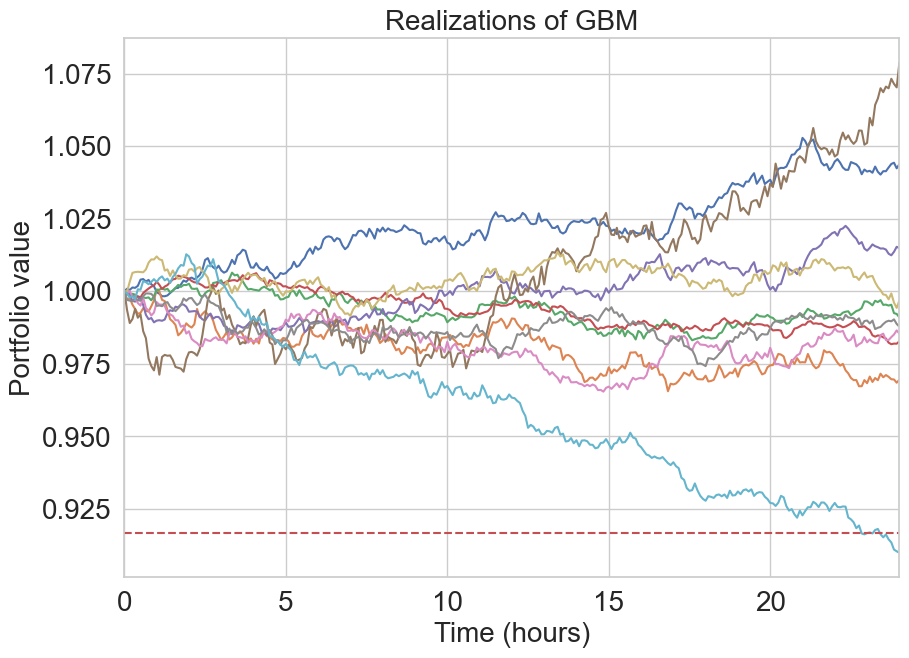

In [76]:
n_steps = int(sim_days * 24 * 60 / 5)
x_values = [(i * 5) / 60 for i in range(n_steps + 1)]

plt.figure(figsize=(10, 7))
for x in range(10):
    values = sim2.value_simulation(n_steps, x % sim2.periods)
    plt.plot(x_values, values)

plt.axhline(y=sim2.critical_value, color="r", linestyle="--")
plt.xlabel("Time (hours)")
plt.ylabel("Portfolio value")
plt.xlim((0, max(x_values)))
plt.title(f"Realizations of GBM")

SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.show()


# t-Distribution GBM


In [41]:
def t_fit(X, dof=3.5, iter=200, eps=1e-6):
    """t estimate scale matrix of multivariate t-distribution.
    Code from: https://gist.github.com/cdipaolo/9dd6794a4f0a2889ef60a5effa419093
    Implementation based on the algorithm detailed in Murphy
    Section 11.4.5 (page 362).

    Args:
        X: dataset (n_samples, n_variables)
        dof: degrees of freedom for likelihood (>2)
        iter: maximum EM iterations
        eps: tolerance for EM convergence

    Returns:
        estimated covariance, estimated mean, list of objectives
    """
    # initialize parameters
    D = X.shape[1]
    N = X.shape[0]
    cov = np.cov(X, rowvar=False)
    mean = X.mean(axis=0)
    mu = X - mean[None, :]
    delta = np.einsum("ij,ij->i", mu, np.linalg.solve(cov, mu.T).T)
    z = (dof + D) / (dof + delta)
    obj = [
        -N * np.linalg.slogdet(cov)[1] / 2
        - (z * delta).sum() / 2
        - N * special.gammaln(dof / 2)
        + N * dof * np.log(dof / 2) / 2
        + dof * (np.log(z) - z).sum() / 2
    ]

    # iterate
    for i in range(iter):
        # M step
        mean = (X * z[:, None]).sum(axis=0).reshape(-1, 1) / z.sum()
        mu = X - mean.squeeze()[None, :]
        cov = np.einsum("ij,ik->jk", mu, mu * z[:, None]) / N

        # E step
        delta = (mu * np.linalg.solve(cov, mu.T).T).sum(axis=1)
        delta = np.einsum("ij,ij->i", mu, np.linalg.solve(cov, mu.T).T)
        z = (dof + D) / (dof + delta)

        # store objective
        obj.append(
            -N * np.linalg.slogdet(cov)[1] / 2
            - (z * delta).sum() / 2
            - N * special.gammaln(dof / 2)
            + N * dof * np.log(dof / 2) / 2
            + dof * (np.log(z) - z).sum() / 2
        )

        if np.abs(obj[-1] - obj[-2]) < eps:
            break
    return cov, mean.squeeze(), obj


In [42]:
class SimulationTPrices(Simulation):
    """Simulation class simulating prices separately for each asset in portfolio."""

    def __init__(
        self, returns, portfolio, initial_overcol, expected_overcol, time_block
    ):
        """Initialize simulation object with given portfolio defined by weights.

        Args:
            returns: dataframe with log returns for different tokens
            portfolio: portfolio defined as mapping of token to percentage in portfolio
            initial_overcol: value of initial overcollaterization
            expected_overcol: value of expected overcollaterization
            time_block: size of historical time block to use for the simulation
        """
        super().__init__(
            returns, portfolio, initial_overcol, expected_overcol, time_block
        )

        self.means, self.volatility, self.df, self.mats = [], [], [], []
        for i in range(0, len(self.returns), time_block):
            rets = self.returns[self._symbols].values[i : i + time_block]

            params = [t.fit(rets[:, s]) for s in range(len(self._symbols))]
            params = np.array(params).T

            dof = self.combined_dof(params[0])
            mat, means = None, params[1]
            if len(self._symbols) > 1:
                mat, means, _ = t_fit(rets, dof=dof, iter=1000)

            self.df.append(params[0])
            self.means.append(means)
            self.volatility.append(params[2])
            self.mats.append(mat)

    def combined_dof(self, dofs):
        """Calculate combined dof for the multivariate_t."""
        # DOF must be bigger than 2
        return max(np.mean(dofs), 2.1)

    def value_simulation(self, steps, period=0):
        """Simulate prices for each asset separately."""
        # Generate random normal values with same covariance as covariance of original returns
        if len(self._symbols) > 1:
            dof = self.combined_dof(self.df[period])
            random_vals = multivariate_t.rvs(
                self.means[period],
                self.mats[period],
                dof,
                steps,
            )
        else:
            random_vals = t.rvs(
                self.df[period], self.means[period], self.volatility[period], steps
            )
            random_vals = np.expand_dims(random_vals, axis=-1)

        sim_returns = np.exp(random_vals)
        sim_returns = np.vstack([np.ones((len(self._symbols),)), sim_returns])
        values = (self._v * sim_returns.cumprod(axis=0)).sum(axis=1)
        return values


In [43]:
portfolio = {"BTC": 0.5, "ETH": 0.5}
sim_days = 1
initial_overcol = 1.2
expected_overcol = 1.1
# How many days of historical data to use for simulation
time_block = int(7 * (24 * 60 / 5))

sim3 = SimulationTPrices(
    returns, portfolio, initial_overcol, expected_overcol, time_block
)

mean = sim3.simulate(sim_days, 100000)


Periods: 8
Mean: [3.1190684668011384e-05, -4.280897891651729e-05, -6.384906458619516e-06, 1.3207221769977911e-05, 9.268670984672163e-05, -0.00012423214011432284, -1.3082963671177486e-05, -2.23779724808271e-05]
Vol: [0.0014903285561325271, 0.0016782579143553747, 0.0010037935147006515, 0.00074552446677176, 0.0013713341324605639, 0.003169883373728718, 0.0013888896349384602, 0.0013232624173180392]
0.02281 +- 0.00047212209013419395


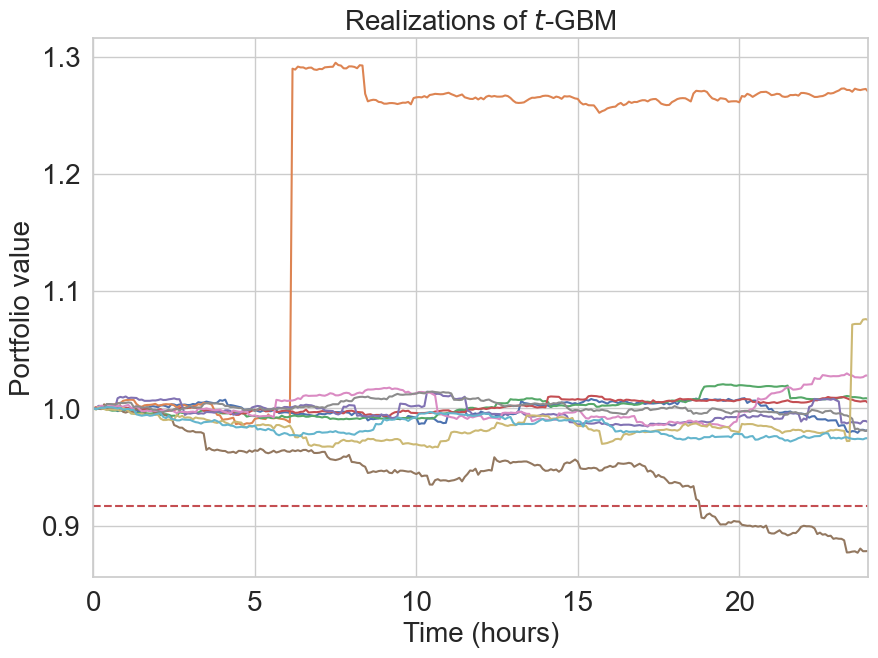

In [101]:
n_steps = int(sim_days * 24 * 60 / 5)
x_values = [(i * 5) / 60 for i in range(n_steps + 1)]



plt.figure(figsize=(10, 7))
for x in range(10):
    values = sim3.value_simulation(n_steps, x % sim3.periods)
    plt.plot(x_values, values)

plt.axhline(y=sim2.critical_value, color="r", linestyle="--")
plt.xlabel("Time (hours)")
plt.ylabel("Portfolio value")
plt.xlim((0, max(x_values)))
plt.title(f"Realizations of $t$-GBM")

SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.show()


# Historical Simulation

Estimating values using historical data and iterating over them


In [22]:
class HistoricalSimulation(Simulation):
    def value_simulation(self, steps, period=0, start=0):
        """Simulate one value (price) path using GBM based on mu and sigma."""
        returns = self.returns[self._symbols].values[start : start + steps]
        returns = np.vstack([np.ones((len(self._symbols),)), np.exp(returns)])
        values = (self._v * returns.cumprod(axis=0)).sum(axis=1)
        return values

    def simulate(self, sim_days, runs, log=True):
        """Run the simulation and calculate the percentage of failures.

        Args:
            sim_days: number of days to simulate
            runs: number of runs of the simulation (unused, for compatibility)
            log: print final results if true
        """
        n_steps = int(sim_days * 24 * 60 / 5)

        stats = []
        # Use step of 10 to make it bit faster (not changing results much)
        for i in range(0, len(self.returns) - n_steps + 1, 10):
            values = self.value_simulation(n_steps, start=i)
            failed = self._check_condition(values)
            stats.append(failed)

        stats = np.array(stats)
        if log:
            print(f"{stats.mean()} +- {sem(stats)}")
        return stats, stats.mean()


In [23]:
portfolio = {"BTC": 0.5, "ETH": 0.5}
sim_days = 1
initial_overcol = 1.2
expected_overcol = 1.1
# How many days of historical data to use for simulation
time_block = int(7 * (24 * 60 / 5))

sim3 = HistoricalSimulation(
    returns, portfolio, initial_overcol, expected_overcol, time_block
)

mean = sim3.simulate(sim_days, 100000)


Periods: 8
Mean: [3.1190684668011384e-05, -4.280897891651729e-05, -6.384906458619516e-06, 1.3207221769977911e-05, 9.268670984672163e-05, -0.00012423214011432284, -1.3082963671177486e-05, -2.23779724808271e-05]
Vol: [0.0014903285561325271, 0.0016782579143553747, 0.0010037935147006515, 0.00074552446677176, 0.0013713341324605639, 0.003169883373728718, 0.0013888896349384602, 0.0013232624173180392]
0.061155913978494625 +- 0.006213845970986324


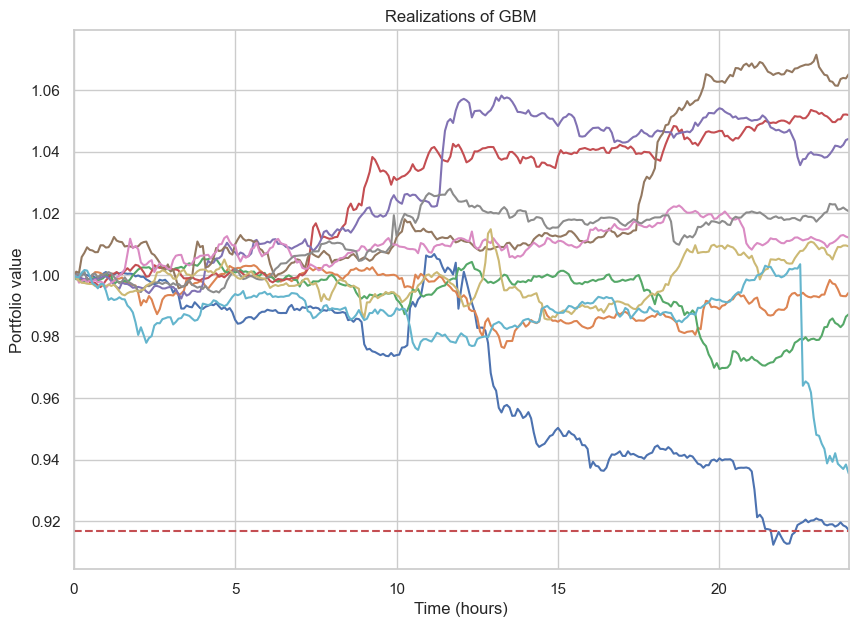

In [24]:
n_steps = int(sim_days * 24 * 60 / 5)
x_values = [(i * 5) / 60 for i in range(n_steps + 1)]

plt.figure(figsize=(10, 7))
for x in range(10):
    values = sim3.value_simulation(n_steps, start=x * 300)
    plt.plot(x_values, values)

plt.axhline(y=sim2.critical_value, color="r", linestyle="--")
plt.xlabel("Time (hours)")
plt.ylabel("Portfolio value")
plt.xlim((0, max(x_values)))
plt.title(f"Realizations of GBM")
plt.show()


## Testing different portfolios


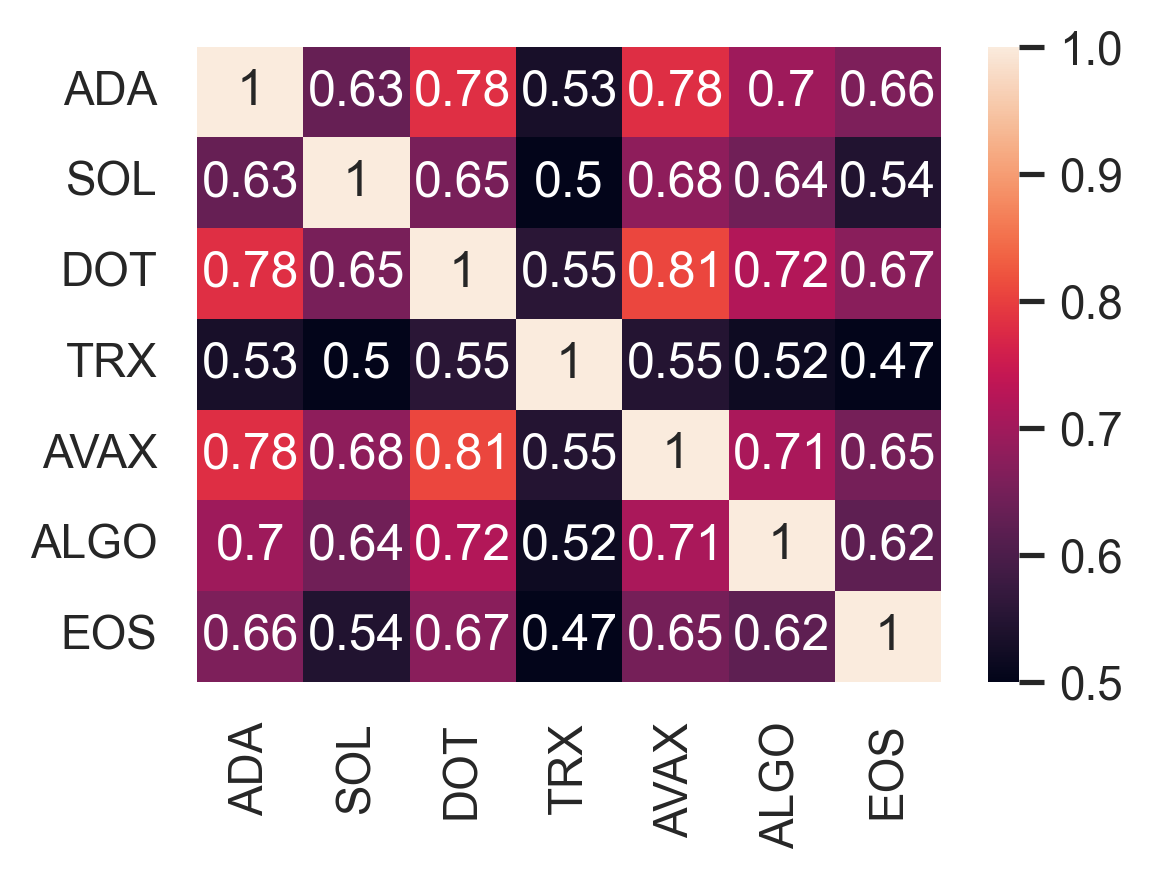

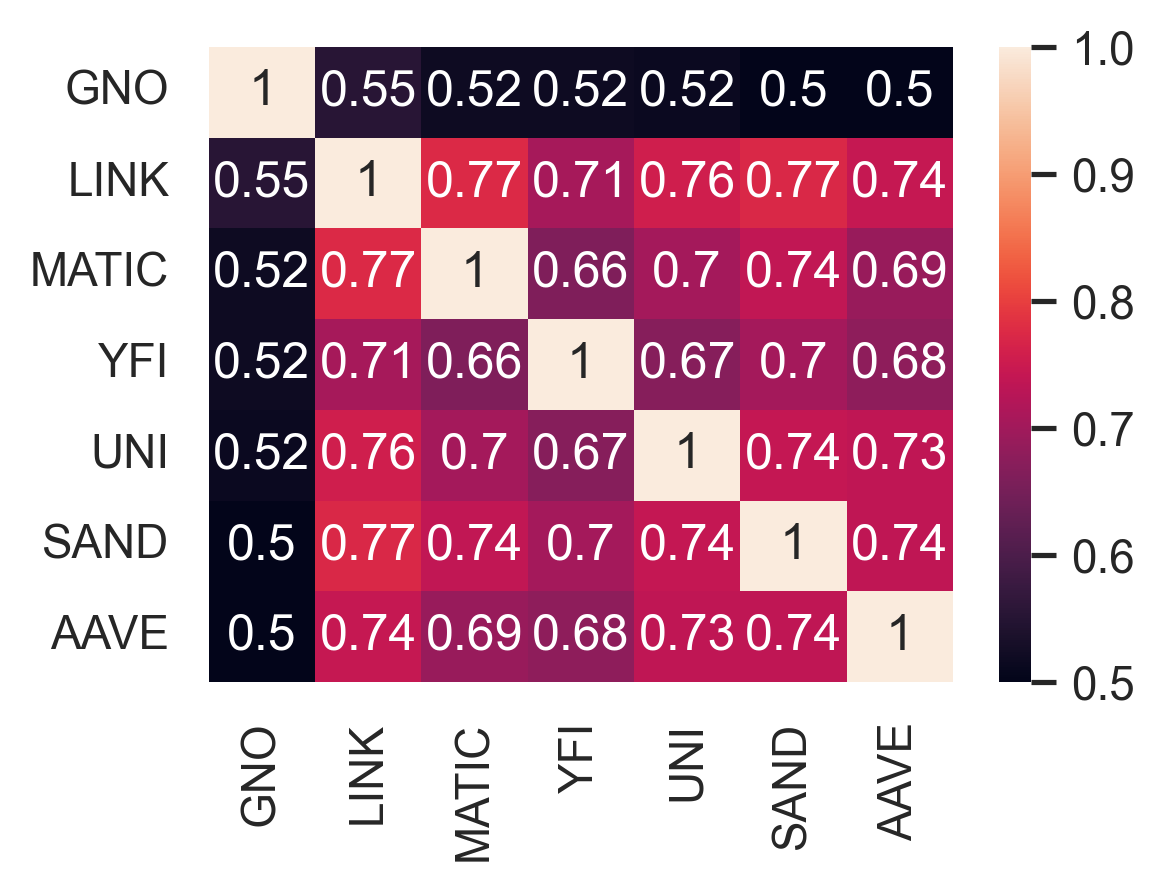

In [25]:
symbols = ["ADA", "SOL", "DOT", "TRX", "AVAX", "ALGO", "EOS"]
fig, ax = plt.subplots(1, 1, figsize = (4, 2.75), dpi=300)
sns.heatmap(returns[symbols].corr(), annot=True, vmin=0.5)
ax.set_ylabel('')    
ax.set_xlabel('')
plt.show()

symbols = ["GNO", "LINK", "MATIC", "YFI", "UNI", "SAND", "AAVE"]
fig, ax = plt.subplots(1, 1, figsize = (4, 2.75), dpi=300)
sns.heatmap(returns[symbols].corr(), annot=True, vmin=0.5)
ax.set_ylabel('')    
ax.set_xlabel('')
plt.show()


In [27]:
def test_porfolios(simulator_class):
    portfolios = {
        "BTC": [["BTC", 1.0]],
        "ETH": [["ETH", 1.0]],
        "ADA": [["ADA", 1.0]],
        "SOL": [["SOL", 1.0]],
        "DOT": [["DOT", 1.0]],
        "TRX": [["TRX", 1.0]],
        "AVAX": [["AVAX", 1.0]],
        "ALGO": [["ALGO", 1.0]],
        "EOS": [["EOS", 1.0]],
        "DSS-All": [["USDC", 0.47], ["ETH", 0.19], ["PAXG", 0.14], ["USDP", 0.10], ["USDT", 0.08], ["WBTC", 0.02]],
        "DSS-ERC": [["ETH", 0.902], ["WBTC", 0.094], ["GNO", 0.002], ["LINK", 0.001], ["MATIC", 0.0005], ["YFI", 0.0005]],
        "DSS-Mix1": [["ETH", 0.50], ["WBTC", 0.30], ["GNO", 0.05], ["LINK", 0.05], ["MATIC", 0.05], ["YFI", 0.05]],
        "DSS-Mix2": [["ETH", 0.20], ["WBTC", 0.20], ["GNO", 0.15], ["LINK", 0.15], ["MATIC", 0.15], ["YFI", 0.15]],
        "CCDai-Mix1": [["ETH", 0.50], ["WBTC", 0.30], ["ADA", 0.05], ["DOT", 0.05], ["TRX", 0.05], ["AVAX", 0.05]],
        "CCDai-Mix2": [["ETH", 0.20], ["WBTC", 0.20], ["ADA", 0.15], ["DOT", 0.15], ["TRX", 0.15], ["AVAX", 0.15]],
#         "D-Opt": [["ETH", 0.16382], ["WBTC", 0.19254], ["GNO", 0.19256], ["LINK", 0.15551], ["MATIC", 0.13689], ["YFI", 0.15868]],
#         "C-Opt": [["ETH", 0.1579], ["WBTC", 0.1845], ["ADA", 0.15698], ["DOT", 0.16343], ["TRX", 0.1893], ["AVAX", 0.14789]],
#         "Dai-ERC20": ["TRX", "AVAX", "ALGO"],
#         "ALGO-DOT-ADA": ["ALGO", "DOT", "ADA"],
#         "Blockchains": ["ADA", "SOL", "DOT", "TRX", "AVAX", "ALGO", "EOS"],
#         "ERC20": ["SHIB", "UNI", "LINK", "APE", "SAND", "AAVE", "MATIC"],
    }
    sim_days = 1
    # initial_overcol = 1.1
    expected_overcol = 1.1
    # How many days of historical data to use for simulation
    time_block = int(7 * (24 * 60 / 5))

    table = pd.DataFrame({})

    # TODO: Speed up! switch loops
    for name, maps in portfolios.items():
        initial_overcol = 1.15
        # Generate portfolio where each asset has same percentage
        portfolio = {s[0]: s[1] for s in maps}
        print(portfolio)

        sim2 = simulator_class(
            returns, portfolio, initial_overcol, expected_overcol, time_block
        )

        for initial_overcol in np.arange(1.2, 1.51, 0.10):
            sim2.update_initial_overcol(initial_overcol)
            _, mean = sim2.simulate(sim_days, 100000)
            table.loc[initial_overcol, name] = mean

        print()

    sns.set(rc={"figure.figsize": (14, 8)})
    sns.heatmap(table, annot=True)
    plt.show()
    return table

In [ ]:
table = test_porfolios(Simulation)


In [28]:
print(table.iloc[:, :9].to_latex(float_format="%.3f"))
print(table.iloc[:, 9:].to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrrrrrr}
\toprule
 & BTC & ETH & ADA & SOL & DOT & TRX & AVAX & ALGO & EOS \\
\midrule
1.200000 & 0.025 & 0.047 & 0.043 & 0.144 & 0.037 & 0.025 & 0.072 & 0.120 & 0.068 \\
1.300000 & 0.000 & 0.004 & 0.003 & 0.069 & 0.002 & 0.001 & 0.010 & 0.024 & 0.007 \\
1.400000 & 0.000 & 0.000 & 0.000 & 0.039 & 0.000 & 0.000 & 0.001 & 0.004 & 0.000 \\
1.500000 & 0.000 & 0.000 & 0.000 & 0.020 & 0.000 & 0.000 & 0.000 & 0.001 & 0.000 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrr}
\toprule
 & DSS-All & DSS-ERC & DSS-Mix1 & DSS-Mix2 & CCDai-Mix1 & CCDai-Mix2 \\
\midrule
1.200000 & 0.000 & 0.042 & 0.038 & 0.042 & 0.034 & 0.031 \\
1.300000 & 0.000 & 0.004 & 0.002 & 0.003 & 0.002 & 0.001 \\
1.400000 & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 \\
1.500000 & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 \\
\bottomrule
\end{tabular}



{'BTC': 1.0}
Periods: 8
Mean: [3.592112766413989e-05, -3.7324505910266015e-05, -3.691960256215483e-06, 5.30677349900328e-06, 6.080276714441855e-05, -0.0001176433318169405, -4.801508911318334e-06, -8.200131573142067e-06]
Vol: [0.001243158159949874, 0.0015490622624597604, 0.0009099833504667615, 0.0006799742819543922, 0.0010220788943124334, 0.002733649033573843, 0.001304176516299487, 0.0010981436934478486]
0.02391 +- 0.00048309983735717445
0.00056 +- 7.481256558359492e-05
1e-05 +- 9.999999999999999e-06
0.0 +- 0.0

{'ETH': 1.0}
Periods: 8
Mean: [2.6460241671882878e-05, -4.829345192276857e-05, -9.077852661023548e-06, 2.110767004095254e-05, 0.00012457065254902473, -0.00013082094841170518, -2.136441843103664e-05, -3.6555813388512135e-05]
Vol: [0.0018424412212552366, 0.0019089080847495999, 0.0011457913356588642, 0.0008648317219032673, 0.0018267929609003001, 0.003772459842283967, 0.0015662906722269233, 0.0016399147039153341]
0.04613 +- 0.0006633435243117344
0.00471 +- 0.00021651472879755286
0.0

0.0 +- 0.0
0.0 +- 0.0



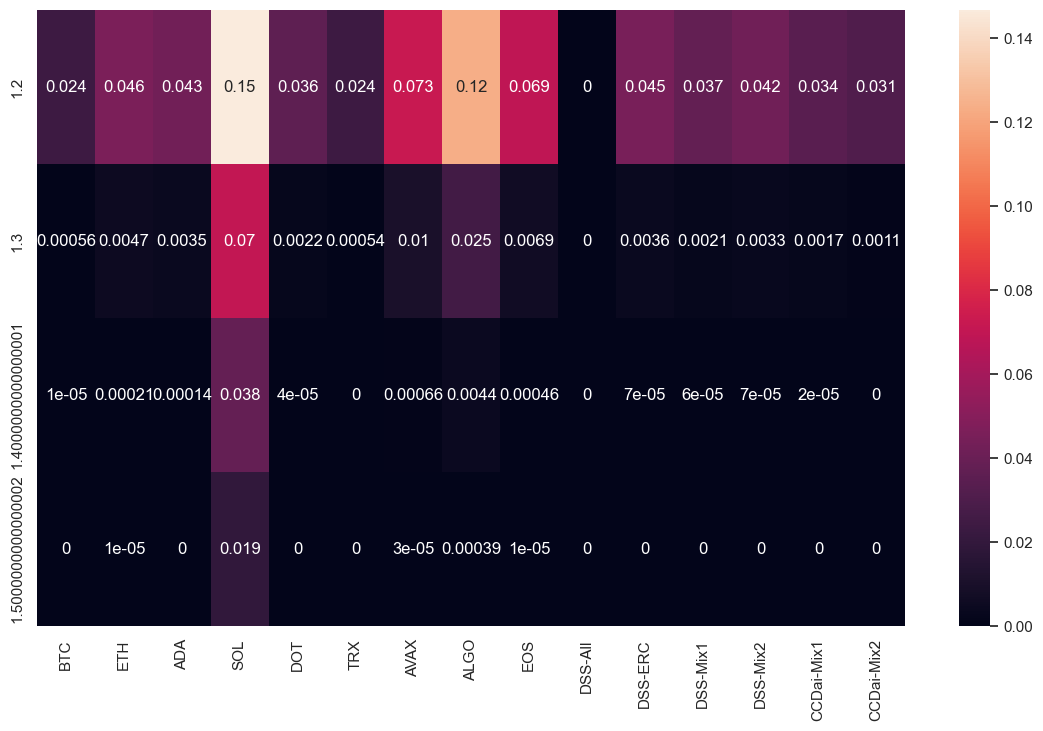

In [29]:
table = test_porfolios(SimulationPrices)


In [30]:
print(table.iloc[:, :9].to_latex(float_format="%.3f"))
print(table.iloc[:, 9:].to_latex(float_format="%.3f"))


\begin{tabular}{lrrrrrrrrr}
\toprule
 & BTC & ETH & ADA & SOL & DOT & TRX & AVAX & ALGO & EOS \\
\midrule
1.200000 & 0.024 & 0.046 & 0.043 & 0.147 & 0.036 & 0.024 & 0.073 & 0.124 & 0.069 \\
1.300000 & 0.001 & 0.005 & 0.003 & 0.070 & 0.002 & 0.001 & 0.010 & 0.025 & 0.007 \\
1.400000 & 0.000 & 0.000 & 0.000 & 0.038 & 0.000 & 0.000 & 0.001 & 0.004 & 0.000 \\
1.500000 & 0.000 & 0.000 & 0.000 & 0.019 & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrr}
\toprule
 & DSS-All & DSS-ERC & DSS-Mix1 & DSS-Mix2 & CCDai-Mix1 & CCDai-Mix2 \\
\midrule
1.200000 & 0.000 & 0.045 & 0.037 & 0.042 & 0.034 & 0.031 \\
1.300000 & 0.000 & 0.004 & 0.002 & 0.003 & 0.002 & 0.001 \\
1.400000 & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 \\
1.500000 & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 \\
\bottomrule
\end{tabular}



{'BTC': 1.0}
Periods: 8
Mean: [3.592112766413989e-05, -3.7324505910266015e-05, -3.691960256215483e-06, 5.30677349900328e-06, 6.080276714441855e-05, -0.0001176433318169405, -4.801508911318334e-06, -8.200131573142067e-06]
Vol: [0.001243158159949874, 0.0015490622624597604, 0.0009099833504667615, 0.0006799742819543922, 0.0010220788943124334, 0.002733649033573843, 0.001304176516299487, 0.0010981436934478486]
0.02151 +- 0.0004587758752953749
0.00307 +- 0.00017494586894399822
0.00105 +- 0.00010241620912140276
0.00071 +- 8.423200074971209e-05

{'ETH': 1.0}
Periods: 8
Mean: [2.6460241671882878e-05, -4.829345192276857e-05, -9.077852661023548e-06, 2.110767004095254e-05, 0.00012457065254902473, -0.00013082094841170518, -2.136441843103664e-05, -3.6555813388512135e-05]
Vol: [0.0018424412212552366, 0.0019089080847495999, 0.0011457913356588642, 0.0008648317219032673, 0.0018267929609003001, 0.003772459842283967, 0.0015662906722269233, 0.0016399147039153341]
0.04729 +- 0.000671223557699403
0.00779 +- 0.

0.02869 +- 0.0005278935742327775
0.00348 +- 0.00018622363650307102
0.001 +- 9.995048724743172e-05
0.00064 +- 7.997479577766733e-05



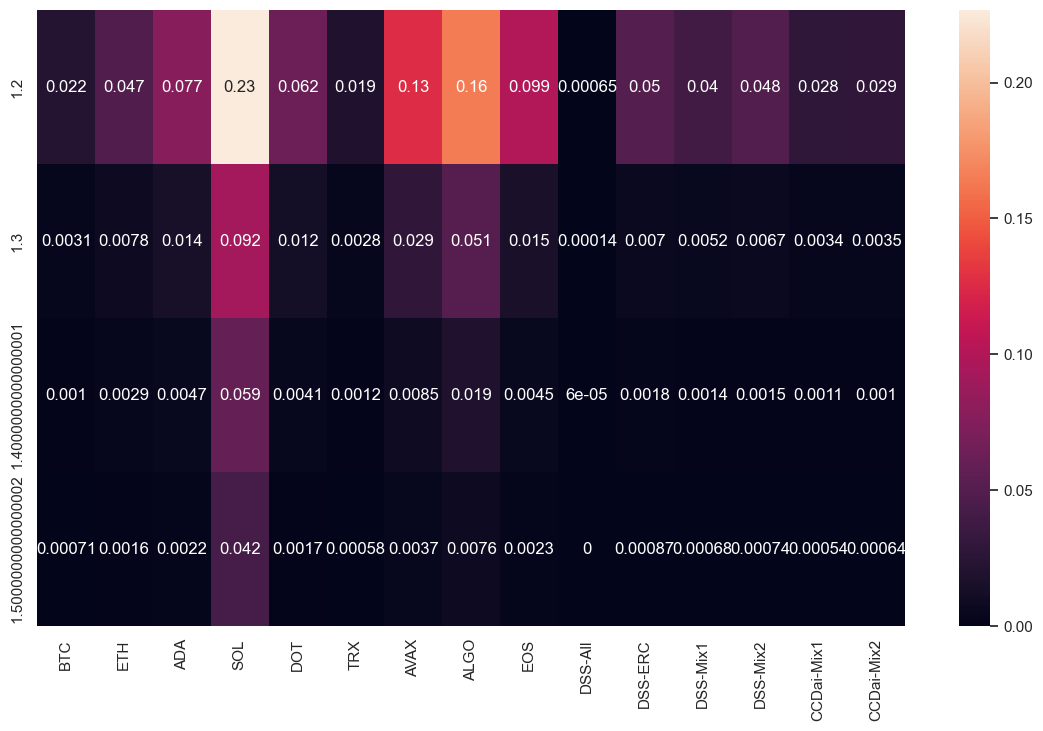

In [31]:
table = test_porfolios(SimulationTPrices)


In [32]:
print(table.iloc[:, :9].to_latex(float_format="%.3f"))
print(table.iloc[:, 9:].to_latex(float_format="%.3f"))


\begin{tabular}{lrrrrrrrrr}
\toprule
 & BTC & ETH & ADA & SOL & DOT & TRX & AVAX & ALGO & EOS \\
\midrule
1.200000 & 0.022 & 0.047 & 0.077 & 0.227 & 0.062 & 0.019 & 0.126 & 0.164 & 0.099 \\
1.300000 & 0.003 & 0.008 & 0.014 & 0.092 & 0.012 & 0.003 & 0.029 & 0.051 & 0.015 \\
1.400000 & 0.001 & 0.003 & 0.005 & 0.059 & 0.004 & 0.001 & 0.009 & 0.019 & 0.005 \\
1.500000 & 0.001 & 0.002 & 0.002 & 0.042 & 0.002 & 0.001 & 0.004 & 0.008 & 0.002 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrr}
\toprule
 & DSS-All & DSS-ERC & DSS-Mix1 & DSS-Mix2 & CCDai-Mix1 & CCDai-Mix2 \\
\midrule
1.200000 & 0.001 & 0.050 & 0.040 & 0.048 & 0.028 & 0.029 \\
1.300000 & 0.000 & 0.007 & 0.005 & 0.007 & 0.003 & 0.003 \\
1.400000 & 0.000 & 0.002 & 0.001 & 0.002 & 0.001 & 0.001 \\
1.500000 & 0.000 & 0.001 & 0.001 & 0.001 & 0.001 & 0.001 \\
\bottomrule
\end{tabular}



{'BTC': 1.0}
Periods: 8
Mean: [3.592112766413989e-05, -3.7324505910266015e-05, -3.691960256215483e-06, 5.30677349900328e-06, 6.080276714441855e-05, -0.0001176433318169405, -4.801508911318334e-06, -8.200131573142067e-06]
Vol: [0.001243158159949874, 0.0015490622624597604, 0.0009099833504667615, 0.0006799742819543922, 0.0010220788943124334, 0.002733649033573843, 0.001304176516299487, 0.0010981436934478486]
0.05174731182795699 +- 0.005744476458518468
0.0020161290322580645 +- 0.001163229583476892
0.0 +- 0.0
0.0 +- 0.0

{'ETH': 1.0}
Periods: 8
Mean: [2.6460241671882878e-05, -4.829345192276857e-05, -9.077852661023548e-06, 2.110767004095254e-05, 0.00012457065254902473, -0.00013082094841170518, -2.136441843103664e-05, -3.6555813388512135e-05]
Vol: [0.0018424412212552366, 0.0019089080847495999, 0.0011457913356588642, 0.0008648317219032673, 0.0018267929609003001, 0.003772459842283967, 0.0015662906722269233, 0.0016399147039153341]
0.07190860215053764 +- 0.0066993136730695855
0.024193548387096774 +

0.05241935483870968 +- 0.005779608780679032
0.006048387096774193 +- 0.002010698371802288
0.0 +- 0.0
0.0 +- 0.0



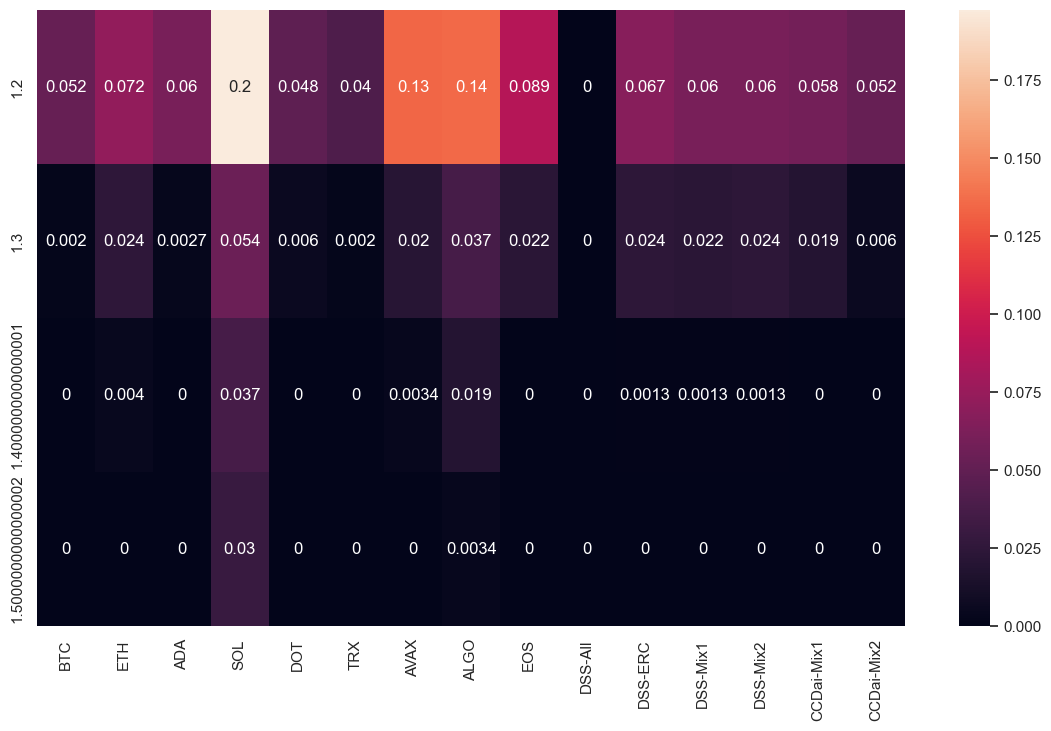

In [28]:
table = test_porfolios(HistoricalSimulation)

In [29]:
print(table.iloc[:, :9].to_latex(float_format="%.3f"))
print(table.iloc[:, 9:].to_latex(float_format="%.3f"))


\begin{tabular}{lrrrrrrrrr}
\toprule
 & BTC & ETH & ADA & SOL & DOT & TRX & AVAX & ALGO & EOS \\
\midrule
1.200000 & 0.052 & 0.072 & 0.060 & 0.198 & 0.048 & 0.040 & 0.134 & 0.135 & 0.089 \\
1.300000 & 0.002 & 0.024 & 0.003 & 0.054 & 0.006 & 0.002 & 0.020 & 0.037 & 0.022 \\
1.400000 & 0.000 & 0.004 & 0.000 & 0.037 & 0.000 & 0.000 & 0.003 & 0.019 & 0.000 \\
1.500000 & 0.000 & 0.000 & 0.000 & 0.030 & 0.000 & 0.000 & 0.000 & 0.003 & 0.000 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrr}
\toprule
 & DSS-All & DSS-ERC & DSS-Mix1 & DSS-Mix2 & CCDai-Mix1 & CCDai-Mix2 \\
\midrule
1.200000 & 0.000 & 0.067 & 0.060 & 0.060 & 0.058 & 0.052 \\
1.300000 & 0.000 & 0.024 & 0.022 & 0.024 & 0.019 & 0.006 \\
1.400000 & 0.000 & 0.001 & 0.001 & 0.001 & 0.000 & 0.000 \\
1.500000 & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 \\
\bottomrule
\end{tabular}



## DCC-GARCH model for dynamic volatility

**This part doesn't work**


In [35]:
class SimulationGARCHPrices(Simulation):
    """Simulation class simulating prices separately for each asset in portfolio.

    Using GARCH model for simulating volatility and t-distribution for returns.
    """

    def __init__(
        self, returns, portfolio, initial_overcol, expected_overcol, time_block
    ):
        """Initialize simulation object with given portfolio defined by weights.

        Args:
            returns: dataframe with log returns for different tokens
            portfolio: portfolio defined as mapping of token to percentage in portfolio
            initial_overcol: value of initial overcollaterization
            expected_overcol: value of expected overcollaterization
            time_block: size of historical time block to use for the simulation
        """
        super().__init__(
            returns, portfolio, initial_overcol, expected_overcol, time_block
        )

        self.means, self.volatility, self.params = [], [], []
        for i in range(0, len(self.returns), time_block):
            rets = self.returns.loc[i : i + time_block, self._symbols]
            self.means.append(rets.mean().values)

            volatility = mgarch.mgarch(dist="t")
            volatility.fit(rets)
            self.volatility.append(volatility)

            self.params.append(
                [volatility.garch_fit(volatility.rt[:, i]) for i in range(volatility.N)]
            )

    def update_volatility(self, volatility, params, returns):
        """Update GARCH volatility object with newly generated returns (in simulation)."""
        volatility.T += 1

        D_t = np.zeros((volatility.N,))
        for i, param in enumerate(params):
            omega, alpha, beta = param
            # TODO: Better update
            D_t[i] = (
                omega
                + alpha * (volatility.rt[-1, i] ** 2)
                + beta * volatility.D_t[-1, i]
            )
        volatility.rt = np.vstack([volatility.rt, returns])
        volatility.D_t = np.vstack([volatility.D_t, D_t])

    def value_simulation(self, steps, period=0):
        """Simulate prices for each asset separately with volatility modeled by GARCH."""
        sim_vol = self.volatility[period]
        params = self.params[period]
        means = self.means[period]

        sim_returns = []
        for i in range(steps):
            pred = sim_vol.predict(1)
            if pred is None:
                raise Exception("Prediciton is none.")
            # cov_matrix = pred["cov"] / (pred["dof"] / (pred["dof"] - 2))
            cov_matrix = pred["cov"]
            pred_returns = multivariate_t.rvs(means, cov_matrix, pred["dof"], size=1)
            # Get random values
            sim_returns.append(np.exp(pred_returns))

            self.update_volatility(sim_vol, params, pred_returns)

        sim_returns = np.vstack([np.ones((len(self._symbols),)), np.array(sim_returns)])
        values = (self._v * sim_returns.cumprod(axis=0)).sum(axis=1)
        return values


In [36]:
# Parameters:
portfolio = {"BTC": 0.5, "ETH": 0.5}
sim_days = 1
initial_overcol = 1.2
expected_overcol = 1.1
# How many days of historical data to use for simulation
time_block = int(7 * (24 * 60 / 5))

sim = SimulationGARCHPrices(
    returns, portfolio, initial_overcol, expected_overcol, time_block
)

# Simulation (for T=1 day, 100000 runs)
_ = sim.simulate(sim_days, 10)


In [ ]:
plt.figure(figsize=(10, 7))
n_steps = int(sim_days * 24 * 60 / 5)
x_values = [(i * 5) / 60 for i in range(n_steps + 1)]
# Visualisation
for x in range(10):
    values = sim.value_simulation(n_steps, x % sim.periods)
    plt.plot(x_values, values)
    print(x)

plt.axhline(y=sim.critical_value, color="r", linestyle="--")
plt.xlabel("Time (hours)")
plt.ylabel("Portfolio value")
plt.xlim((0, max(x_values)))
plt.show()
